In [2]:
import numpy as np 
import matplotlib.pyplot as pt
import pandas as pd

data = pd.read_csv('C:/Users/Drew/Downloads/bandwidth.csv')
data.head()

,hourly_bandwidth
0,1000.496714
1,1000.969408
2,1002.046019
3,1004.702118
4,1007.447816


In [3]:
data.describe()

,hourly_bandwidth
count,10000.000000
mean,1232.634448
std,615.204936
min,193.079868
25%,751.099777
50%,1064.494357
75%,1896.875640
max,2402.361236


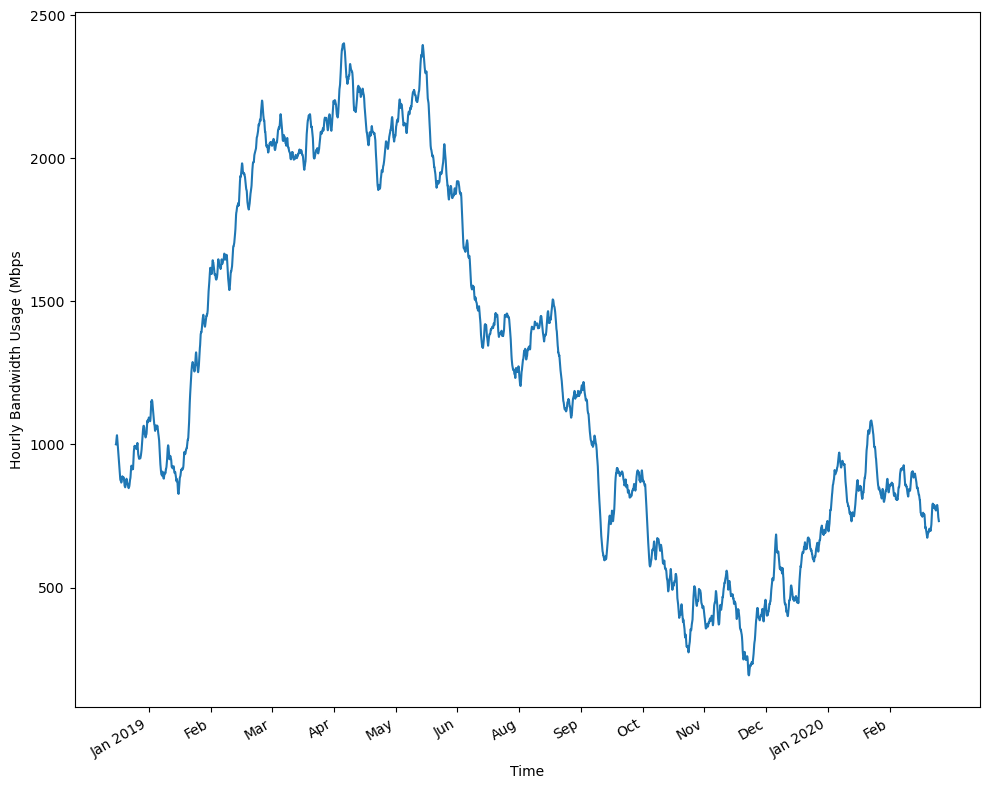

In [4]:
fig, ax = pt.subplots(figsize=(10,8))

ax.plot(data['hourly_bandwidth'])
ax.set_xlabel('Time')
ax.set_ylabel('Hourly Bandwidth Usage (Mbps')
pt.xticks(np.arange(400, 10000, 750),
          ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb'])
fig.autofmt_xdate()
pt.tight_layout()

In [5]:
from statsmodels.tsa.stattools import adfuller

ADF_results = adfuller(data['hourly_bandwidth'])

print(f'ADF Statistic: {ADF_results[0]}')
print(f'P-Value: {ADF_results[1]}')

ADF Statistic: -0.8714653199452924
P-Value: 0.7972240255014491


Not stationary. Perform transformation

In [6]:
bandwidth_diff = np.diff(data['hourly_bandwidth'], n=1)

In [7]:
ADF_results = adfuller(bandwidth_diff)

print(f'ADF Statistic: {ADF_results[0]}')
print(f'P-Value: {ADF_results[1]}')

ADF Statistic: -20.694853863789014
P-Value: 0.0


In [8]:
data_diff = pd.DataFrame({'bandwidth_diff': bandwidth_diff})

train = data_diff[:-2000]
test = data_diff[-2000:]

print(len(train))
print(len(test))

7999
2000


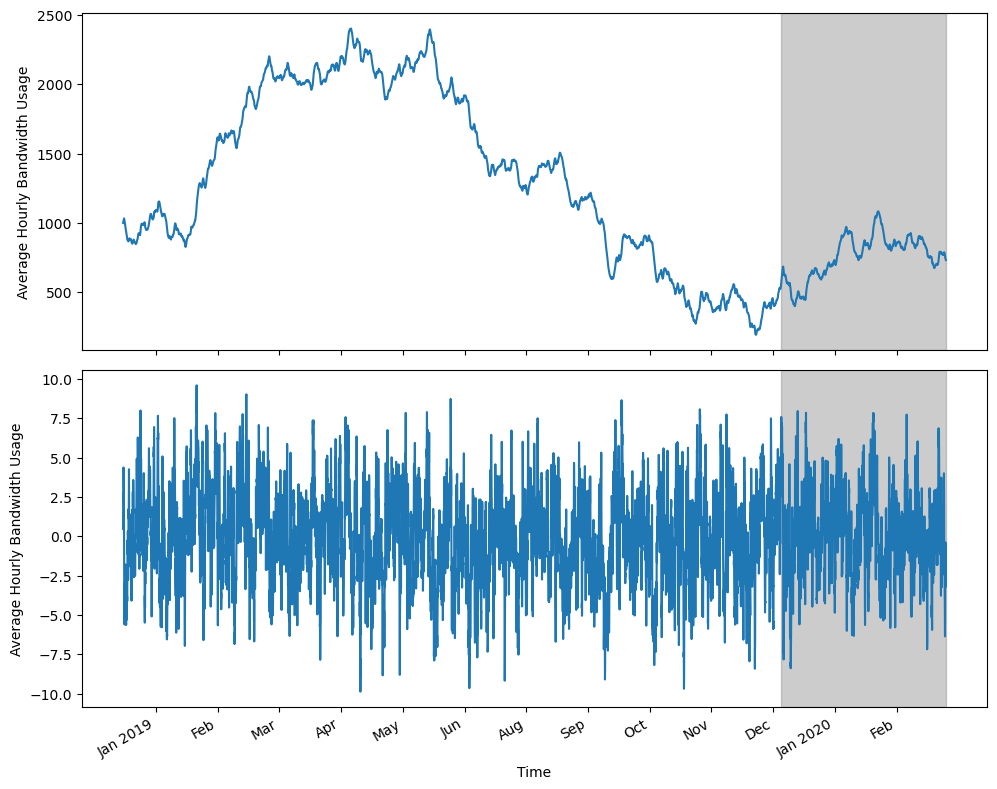

In [9]:
fig, (ax1, ax2) = pt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(data['hourly_bandwidth'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Average Hourly Bandwidth Usage')
ax1.axvspan(8000, 10000, color="#808080", alpha=0.4)

ax2.plot(bandwidth_diff)
ax2.set_xlabel('Time')
ax2.set_ylabel('Average Hourly Bandwidth Usage')
ax2.axvspan(8000, 9999, color="#808080", alpha=0.4)


pt.xticks(np.arange(400, 10000, 750),
          ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb'])
fig.autofmt_xdate()
pt.tight_layout()


Now data is stationary. We can proceed to list the possible values for (p,q)

In [10]:
#Function to fit all unique ARMA(p,q) models
from typing import Union
from tqdm.notebook import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    #Initialize an empty list to store the order (p,q) and its corresponding AIC as a tuple
    results = [] 
    
    #Iterate over each unique (p,q) combination. The use of tqdm_notebook will display a progress bar.
    for order in tqdm(order_list): 
        try:
            #simple_differencing = False to prevent differencing
            #disp=False to avoid printing convergence messages to the console
            model = SARIMAX(endog, order=(order[0], 0, order[1]),
                            simple_differencing = False).fit(disp=False)
        except:
            continue
        
        aic = model.aic #Calculate the model's AIC
        results.append([order,aic]) #Append the (p,q) combination and AIC as a tuple to result list
    
    result_data = pd.DataFrame(results) #Store the combination in a DataFrame
    result_data.columns = ['(p,q)', 'AIC'] #Label the columns of the DataFrame
    
    #Sort in ascending order, lower AIC is better
    result_data = result_data.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_data

In [11]:
from itertools import product

ps = range(0,4,1) #Create a list of possible values for p starting from 0 inclusively to 4 exclusively, with steps of 1
qs = range(0,4,1) #Create a list of possible values of q starting from 0 inclusively to 4 exclusively, with steps of 1


order_list = list(product(ps, qs))

In [12]:
result_data = optimize_ARMA(train['bandwidth_diff'], order_list)
result_data

  0%|          | 0/16 [00:00<?, ?it/s]

C:\Users\Drew\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Drew\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Drew\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,"(p,q)",AIC
0,"(2, 2)",22821.491451
1,"(3, 2)",22821.708988
2,"(2, 3)",22821.908196
3,"(3, 3)",22824.479703
4,"(1, 3)",22829.360183
5,"(1, 2)",22862.040321
6,"(3, 1)",22879.605543
7,"(3, 0)",22895.042138
8,"(2, 0)",22895.805092
9,"(2, 1)",22895.959162


The best model is AIC(2,2). We will select that use it as our order for ARMA. Also, we will be using AR(2) and MA(2) separately as well to make a comparison analysis to study the differences. Now that we have the values for our order, we can proceed to perform residual analysis.

In [13]:
model = SARIMAX(train['bandwidth_diff'], order=(2,0,2), simple_differencing=False)
model_fit = model.fit(disp=False)
residuals = model_fit.resid

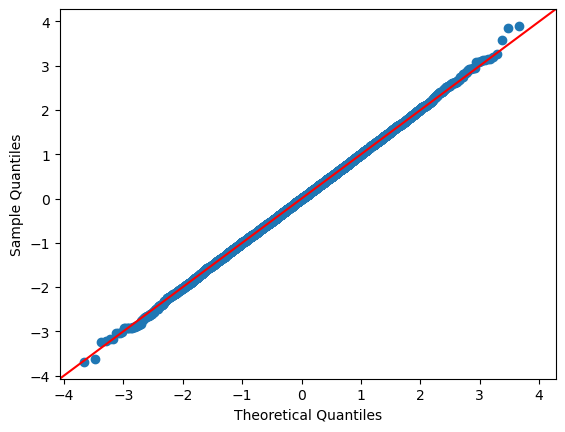

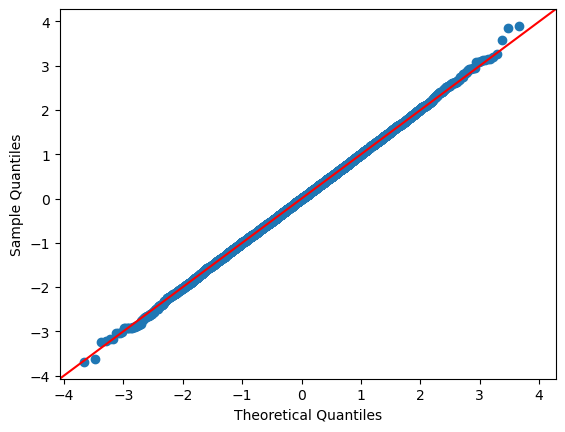

In [14]:
from statsmodels.graphics.gofplots import qqplot

qqplot(residuals, line='45')

The Q-Q plot exhibits a straight line on y=x meaning that the residuals are evenly distributed which are close to the white noise.

In [15]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         bandwidth_diff   No. Observations:                 7999
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -11405.746
Date:                Mon, 29 Apr 2024   AIC                          22821.491
Time:                        00:50:02   BIC                          22856.427
Sample:                             0   HQIC                         22833.449
                               - 7999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3718      0.061      6.097      0.000       0.252       0.491
ar.L2          0.4599      0.056      8.190      0.000       0.350       0.570
ma.L1          0.8406      0.060     14.096      0.0

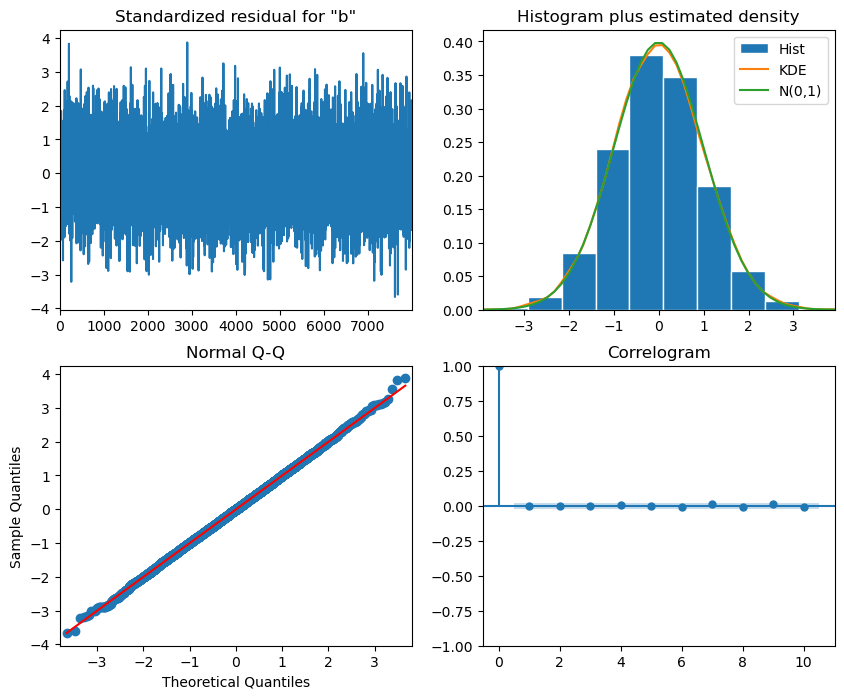

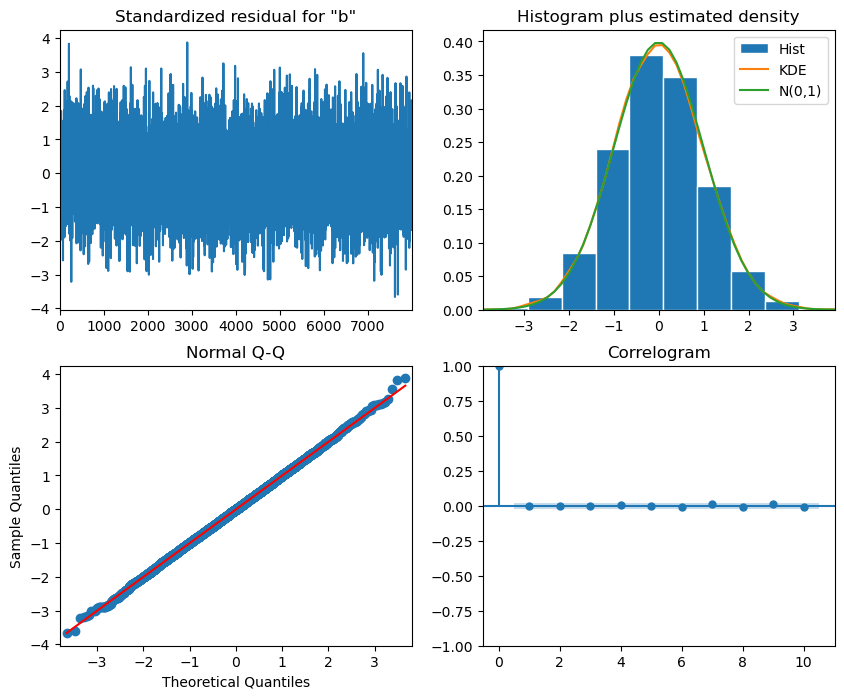

In [16]:
model_fit.plot_diagnostics(figsize=(10,8))

Standardized residual graph shows that there is no trend and the mean seems stable over time. Which indicates stationarity just like white noise.

The histogram exhibits a normally distrutions bell looking shape. Hence, the residuals are normally distributed indicating there are close to white noise.

Q-Q plot exhibits a straight line very close to the y=x line meaning that the residuals are normally distributed as well. Again, indicates that the residuals are close to the white noise. 

The correlogram shows no significant coefficients after lag 0, indicating that there is no significant coefficients at all after lag 0. This means that the residuals are not correlated which further supports the conclusion they are similar to white noise.

In [17]:
from statsmodels.stats.diagnostic import acorr_ljungbox

pvalue = acorr_ljungbox(residuals, np.arange(1,11,1))
print(pvalue)

     lb_stat  lb_pvalue
1   0.026589   0.870470
2   0.255362   0.880134
3   0.307168   0.958675
4   0.536047   0.969898
5   0.540341   0.990572
6   0.867908   0.990128
7   1.614721   0.978070
8   2.366799   0.967653
9   3.530736   0.939504
10  4.144302   0.940603


All the pvalues for each lags are more than 0.05. Thus we cant reject the null hypothesis and can conclude that the residuals are indeed uncorrelated. 

# Forecasting

In [18]:
#The function takes in a DataFrame containing the full simulated moving average process. 
#Train_len: have to pass in the length of training set
#Horizon: have to pass in the length of test set
#Window: How many timesteps we want to predict
#Method: the method we are using
def rolling_forecast(data: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon

    if method == 'AR':
        pred_AR = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(data[:i], order = (2,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
        return pred_AR

    elif method == 'MA':
        pred_MA = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(data[:i], order = (0,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
        return pred_MA

    elif method == 'ARMA':
        pred_ARMA= []
        for i in range(train_len, total_len, window):
            model = SARIMAX(data[:i], order = (2,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
        return pred_ARMA

In [19]:
pred_data = test.copy()

TRAIN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_ARMA = rolling_forecast(data_diff, TRAIN,HORIZON, WINDOW, 'ARMA')
pred_MA = rolling_forecast(data_diff, TRAIN,HORIZON,WINDOW, 'MA')
pred_AR = rolling_forecast(data_diff, TRAIN,HORIZON,WINDOW, 'AR')

pred_data['pred_ARMA'] = pred_ARMA
pred_data['pred_MA'] = pred_MA
pred_data['pred_AR'] = pred_AR

C:\Users\Drew\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Drew\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Drew\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Drew\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Drew\anaconda3\Lib\site-packages\statsmodels\tsa\statespace

In [20]:
pred_data.head()

,bandwidth_diff,pred_ARMA,pred_MA,pred_AR
7999,7.577094,7.567760,5.516075,7.475133
8000,6.355911,6.851105,1.774993,6.838105
8001,5.250430,5.424140,3.910116,5.481529
8002,5.319097,4.803103,1.448102,4.778071
8003,6.249920,4.955949,3.582802,4.896445


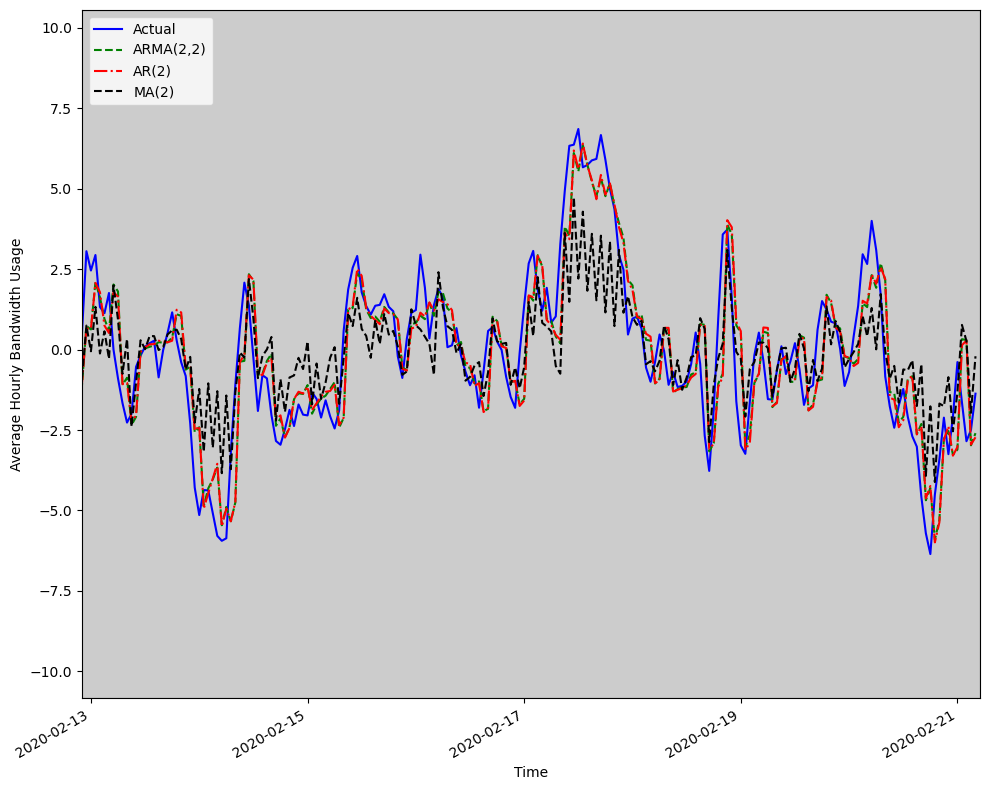

In [21]:
fig, ax = pt.subplots(figsize=(10,8))

ax.plot(data_diff['bandwidth_diff'], 'b-', label="Actual")
ax.plot(pred_data['pred_ARMA'], 'g--', label="ARMA(2,2)")
ax.plot(pred_data['pred_AR'], 'r-.', label="AR(2)")
ax.plot(pred_data['pred_MA'], 'k--', label="MA(2)")
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Average Hourly Bandwidth Usage')
ax.axvspan(8000, 9999, color="#808080", alpha=0.4)
ax.set_xlim(9800, 9999)
pt.xticks(
    [9802, 9850, 9898, 9946, 9994],
    ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])
fig.autofmt_xdate()
pt.tight_layout()

In [22]:
from sklearn.metrics import mean_squared_error

mean_ARMA = mean_squared_error(pred_data['bandwidth_diff'], pred_data['pred_ARMA'])
mean_AR = mean_squared_error(pred_data['bandwidth_diff'], pred_data['pred_AR'])
mean_MA = mean_squared_error(pred_data['bandwidth_diff'], pred_data['pred_MA'])

print("The MSE of ARMA is: ", mean_ARMA)
print("The MSE of AR is: ", mean_AR)
print("The MSE of MA is: ", mean_MA)

The MSE of ARMA is:  1.73669806544807
The MSE of AR is:  1.7624206571946983
The MSE of MA is:  3.172984938359203


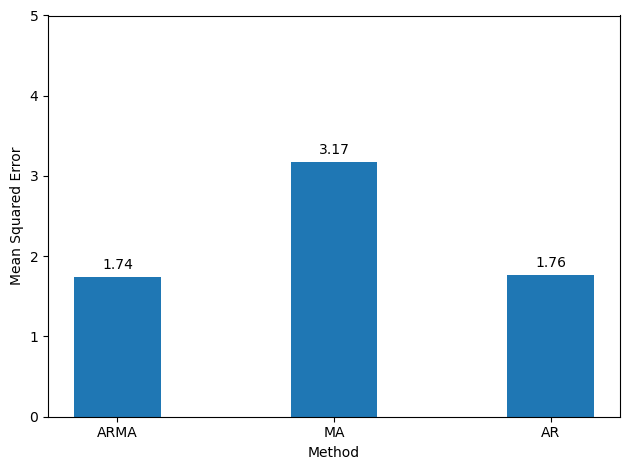

In [26]:
fig, ax = pt.subplots()

x = ['ARMA', 'MA', 'AR']
y = [1.74, 3.17 , 1.76]

ax.bar(x, y, width = 0.4)
ax.set_xlabel('Method')
ax.set_ylabel('Mean Squared Error')
ax.set_ylim(0, 5)

for index, value in enumerate(y):
    pt.text(x=index, y=value + 0.1, s=str(value), ha='center')

pt.tight_layout()

In [23]:
data['pred_bandwidth_ARMA'] = pd.Series()
data['pred_bandwidth_AR'] = pd.Series()
data['pred_bandwidth_MA'] = pd.Series()

data['pred_bandwidth_ARMA'][8000:] = data['hourly_bandwidth'].iloc[8000] + pred_data['pred_ARMA'].cumsum()
data['pred_bandwidth_AR'][8000:] = data['hourly_bandwidth'].iloc[8000] + pred_data['pred_AR'].cumsum()
data['pred_bandwidth_MA'][8000:] = data['hourly_bandwidth'].iloc[8000] + pred_data['pred_MA'].cumsum()

C:\Users\Drew\AppData\Local\Temp\ipykernel_9884\3956596526.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pred_bandwidth_ARMA'][8000:] = data['hourly_bandwidth'].iloc[8000] + pred_data['pred_ARMA'].cumsum()
C:\Users\Drew\AppData\Local\Temp\ipykernel_9884\3956596526.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pred_bandwidth_AR'][8000:] = data['hourly_bandwidth'].iloc[8000] + pred_data['pred_AR'].cumsum()
C:\Users\Drew\AppData\Local\Temp\ipykernel_9884\3956596526.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation:

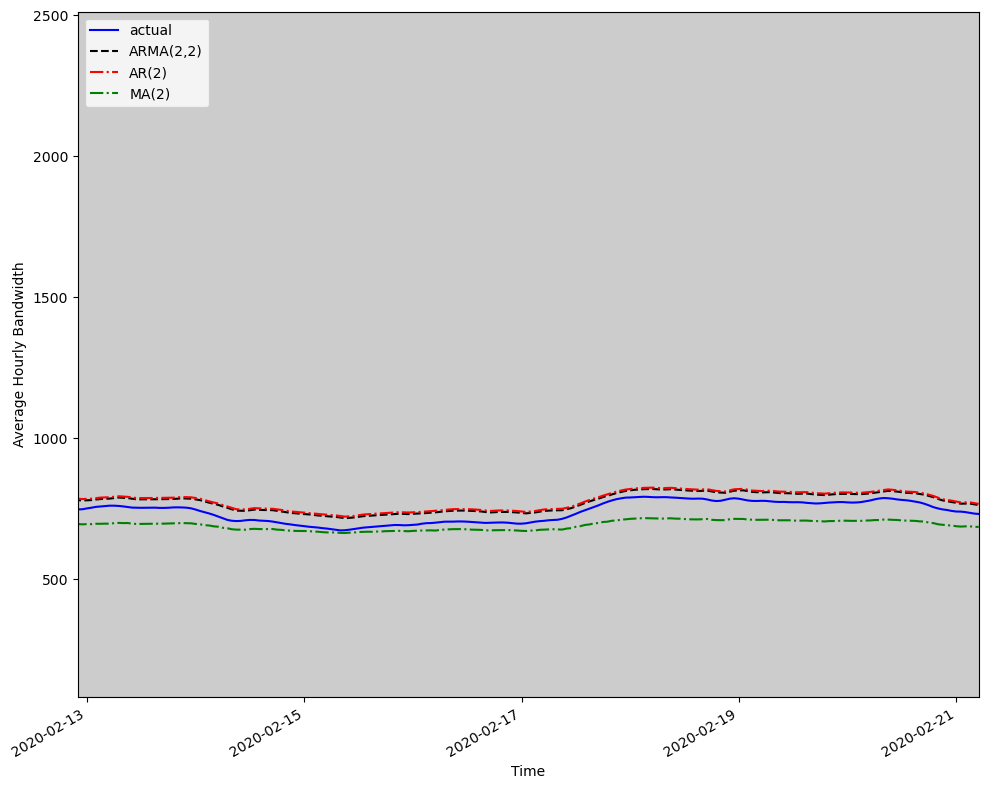

In [24]:
fig, ax = pt.subplots(figsize=(10,8))

ax.plot(data['hourly_bandwidth'], 'b-', label='actual')
ax.plot(data['pred_bandwidth_ARMA'], 'k--', label='ARMA(2,2)')
ax.plot(data['pred_bandwidth_AR'], 'r-.', label='AR(2)')
ax.plot(data['pred_bandwidth_MA'], 'g-.', label='MA(2)')
ax.set_xlabel('Time')
ax.set_ylabel('Average Hourly Bandwidth')
ax.legend(loc=2)
ax.axvspan(8000, 10000, color="#808080", alpha=0.4)
ax.set_xlim(9800, 9999)
pt.xticks(
    [9802, 9850, 9898, 9946, 9994],
    ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])
fig.autofmt_xdate()
pt.tight_layout()

In [25]:
from sklearn.metrics import mean_absolute_error

mae_ARMA = mean_absolute_error(data['hourly_bandwidth'][8000:], data['pred_bandwidth_ARMA'][8000:])
mae_AR = mean_absolute_error(data['hourly_bandwidth'][8000:], data['pred_bandwidth_AR'][8000:])
mae_MA = mean_absolute_error(data['hourly_bandwidth'][8000:], data['pred_bandwidth_MA'][8000:])

print("The MAE of ARMA is: ", mae_ARMA)
print("The MAE of AR is: ", mae_AR)
print("The MAE of MA is: ", mae_MA)

The MAE of ARMA is:  23.014801495663356
The MAE of AR is:  25.927255503320616
The MAE of MA is:  92.66126510696972


Conclusion, ARMA model is the champion model here with the lowest MAE. Though this problem is not relatively suitable for AR because of the PACF showing sinusoidal pattern, but it still performed similar to the ARMA model, just about 3 mbps difference. 

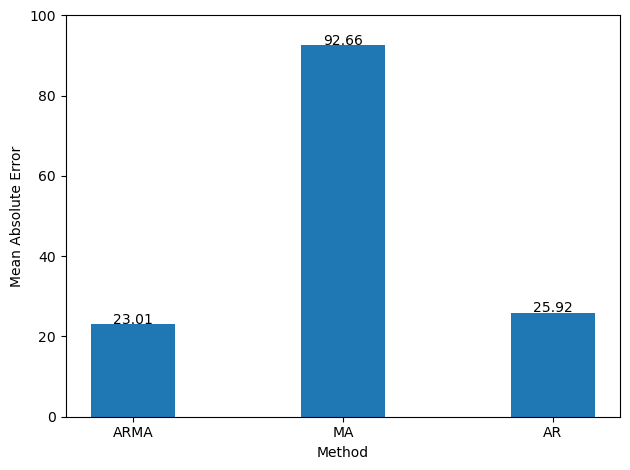

In [27]:
fig, ax = pt.subplots()

x = ['ARMA', 'MA', 'AR']
y = [23.01, 92.66 , 25.92]

ax.bar(x, y, width = 0.4)
ax.set_xlabel('Method')
ax.set_ylabel('Mean Absolute Error')
ax.set_ylim(0, 100)

for index, value in enumerate(y):
    pt.text(x=index, y=value + 0.1, s=str(value), ha='center')

pt.tight_layout()